# Jores et al 2021 Intepretation
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to interpret the best trained models on the Jores et al dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu

Global seed set to 13
2022-08-16 21:19:40.965723: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 21:19:40.965785: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
eu.settings.dataset_dir = "../../_data/datasets/jores21"
eu.settings.output_dir = "../../_output/jores21"
eu.settings.logging_dir = "../../_logs/jores21"
eu.settings.config_dir = "../../_configs/jores21"
eu.settings.batch_size = 128
eu.settings.dl_num_workers = 4
eu.settings.verbosity = logging.ERROR

# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [3]:
# Load in the preprocessed training data
sdata_leaf = eu.dl.read(os.path.join(eu.settings.output_dir, "leaf_test_sub_predictions.h5sd"))
#sdata_proto = eu.dl.read(os.path.join(eu.settings.output_dir, "proto_test_sub_predictions.h5sd"))
#sdata_combined = eu.dl.read(os.path.join(eu.settings.output_dir, "combined_test_sub_predictions.h5sd"))
sdata_leaf, #sdata_proto, sdata_combined

(SeqData object with = 100 seqs
 seqs = (100,)
 names = (100,)
 rev_seqs = (100,)
 ohe_seqs = (100, 170, 4)
 ohe_rev_seqs = (100, 170, 4)
 seqs_annot: 'GC', 'Jores21CNN_test_trial_1_enrichment_predictions', 'Jores21CNN_test_trial_2_enrichment_predictions', 'Jores21CNN_test_trial_3_enrichment_predictions', 'Jores21CNN_test_trial_4_enrichment_predictions', 'Jores21CNN_test_trial_5_enrichment_predictions', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'ssCNN_test_trial_1_enrichment_predictions', 'ssCNN_test_trial_2_enrichment_predictions', 'ssCNN_test_trial_3_enrichment_predictions', 'ssCNN_test_trial_4_enrichment_predictions', 'ssCNN_test_trial_5_enrichment_predictions', 'start', 'strand', 'type'
 pos_annot: None
 seqsm: None
 uns: None,)

# Load the best model

In [4]:
leaf_model_file = glob.glob(os.path.join(eu.settings.logging_dir, "Jores21CNN", f"test_leaf_trial_1", "checkpoints", "*"))[0]
leaf_model = eu.models.Jores21CNN.load_from_checkpoint(leaf_model_file)

In [5]:
saliency_methods = ["InputXGradient", "DeepLift", "GradientSHAP"]#, "NaiveISM"]
for method in saliency_methods:
    eu.interpret.feature_attribution(
        leaf_model,
        sdata_leaf,
        saliency_method=method
    )

No transforms given, assuming just need to tensorize).


Computing saliency on batches: 0it [00:00, ?it/s]

No transforms given, assuming just need to tensorize).


Computing saliency on batches: 0it [00:00, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


No transforms given, assuming just need to tensorize).


Computing saliency on batches: 0it [00:00, ?it/s]

In [6]:
eu.pl.multiseq_track(
    sdata_leaf,
    seq_ids=sdata_leaf.names[:3],
    uns_keys = [method + "_imps" for method in saliency_methods],
    ylabels=saliency_methods
)

Importance values: 0it [00:00, ?it/s]

In [11]:
import logomaker as lm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def lm_seq_track(
    sdata,
    seq_id=None,
    uns_key=None,
    highlights: list = [],
    highlight_colors: list = ["lavenderblush", "lightcyan", "honeydew"],
    ylabel = "Saliency",
    title="",
    return_ax: bool = False,
    save=None,
    **kwargs
):
    if isinstance(highlight_colors, str):
        highlight_colors = [highlight_colors] * len(highlights)

    # Get the sequence and annotations
    seq_idx = np.where(sdata.seqs_annot.index == seq_id)[0][0]
    seq = sdata.seqs[seq_idx]
    imp_scores = sdata.uns[uns_key][seq_idx] if uns_key in sdata.uns.keys() else None
    viz_seq = pd.DataFrame(imp_scores.T, columns=["A", "C", "G", "T"])
    viz_seq.index.name = "pos"
    y_max = np.max(viz_seq.values)
    y_min = np.min(viz_seq.values)
    nn_logo = lm.Logo(
        viz_seq,
        **kwargs
    )

    # style using Logo methods
    nn_logo.style_spines(visible=False)
    nn_logo.style_spines(spines=['left'], visible=True, bounds=[y_min, y_max])

    # style using Axes methods
    nn_logo.ax.set_xlim([0, len(viz_seq)])
    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_ylim([y_min, y_max])
    nn_logo.ax.set_ylabel(ylabel)
    nn_logo.ax.set_title(title)
    for i, highlight in enumerate(highlights):
        nn_logo.highlight_position_range(pmin=highlight[0], pmax=highlight[1], color=highlight_colors[i])
    if return_ax:
        return nn_logo.ax
    if save is not None:
        plt.savefig(save)


def lm_multiseq_track(
    sdata,
    seq_ids: list,
    uns_keys: str = None,
    ylabels: list = None,
    width=None,
    height=None,
    return_axes: bool = False,
    save: str = None,
    **kwargs
):
    if isinstance(seq_ids, str):
        seq_ids = [seq_ids]
    if isinstance(uns_keys, str):
        uns_keys = [uns_keys]
    if isinstance(ylabels, str):
        ylabels = [ylabels]
    ylabels = ylabels if ylabels is not None else ["Importance Score"] * len(uns_keys)
    fig_width = len(seq_ids) * int(170 / 20) if width is None else width # make each sequence width proportional to its length and multiply by the number of sequences
    fig_height = len(uns_keys)*4 if height is None else height # make each sequence height proportional to the number of uns_keys
    _, ax = plt.subplots(len(uns_keys), len(seq_ids), figsize=(fig_width, fig_height))
    for i, uns_key in tqdm(enumerate(uns_keys), desc=f"Importance values", position=0):
        for j, seq_id in enumerate(seq_ids):
            lm_seq_track(
                sdata,
                seq_id=seq_id,
                uns_key=uns_key,
                ax=ax.flatten()[i*len(seq_ids)+j],
                ylabel=ylabels[i],
                title=seq_id,
                save=None,
                **kwargs
            )

    plt.tight_layout()
    if return_axes:
        return ax
    if save is not None:
        plt.savefig(save)

In [14]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Importance values: 0it [00:00, ?it/s]

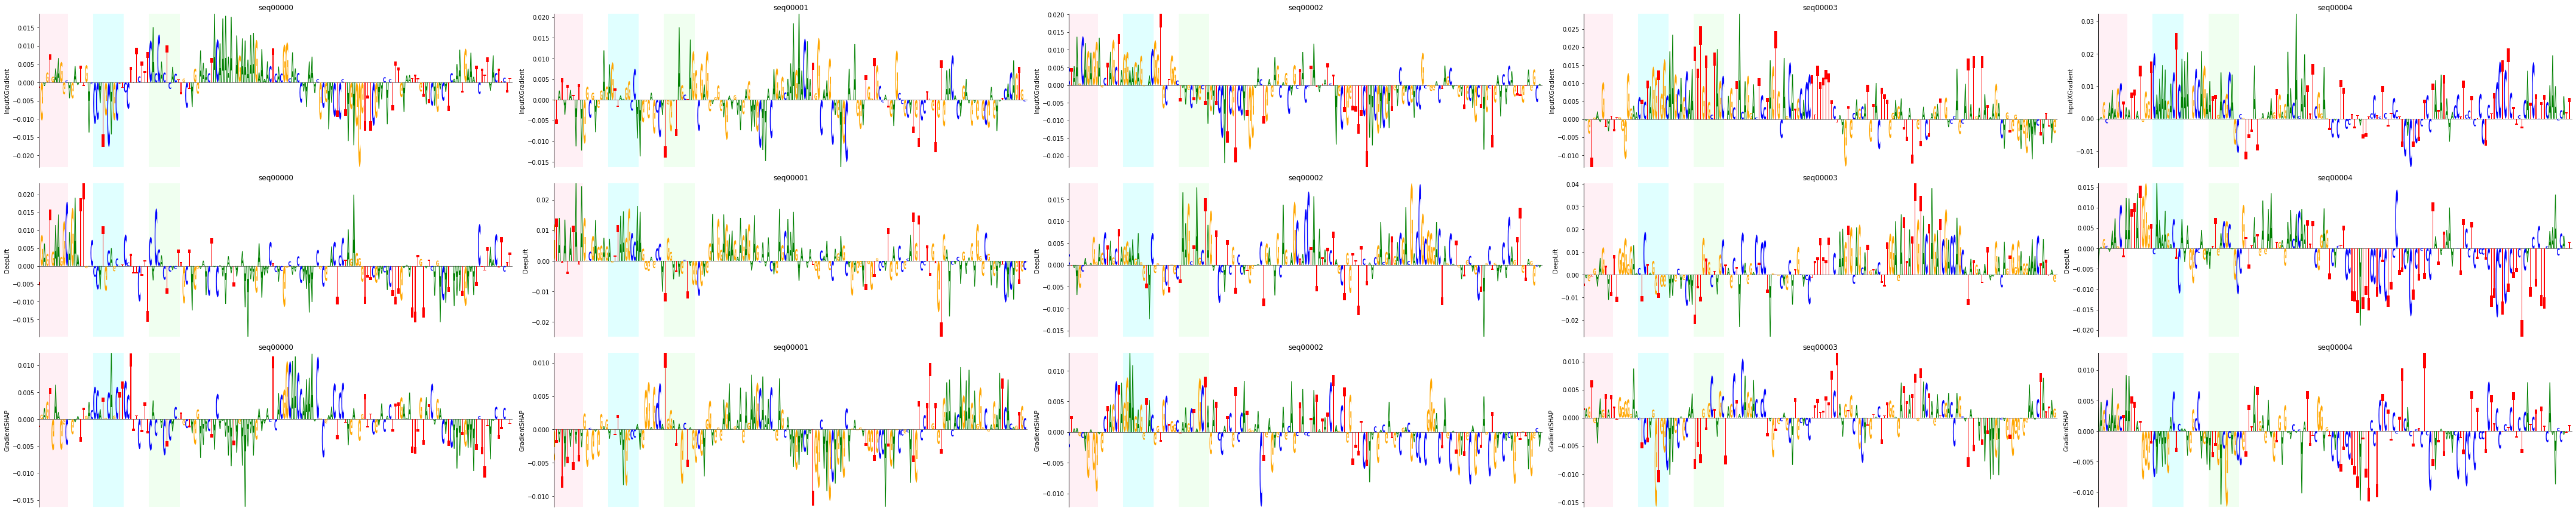

In [17]:
lm_multiseq_track(
    sdata_leaf, 
    seq_ids=sdata_leaf.names[:5],
    uns_keys = [method + "_imps" for method in saliency_methods],
    ylabels=saliency_methods,
    highlights=[(0, 10), (20, 30), (40, 50)], 
    width=60, 
    height=12,
    save=os.path.join(eu.settings.output_dir, "leaf_saliency_track.pdf")
)

# Filter viz

In [18]:
eu.interpret.generate_pfms(leaf_model, sdata_leaf)

cpu
No transforms given, assuming just need to tensorize).
cpu


Getting maximial activating seqlets: 0it [00:00, ?it/s]

Decoding DNA sequences:   0%|          | 0/100 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/128 [00:00<?, ?it/s]

In [44]:
import logomaker as lm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def lm_filter_viz(
    sdata, 
    filter_id=None, 
    uns_key="pfms", 
    save: str = None, 
    title=None,
    **kwargs):

    pfm=sdata_leaf.uns["pfms"][filter_id]
    info_mat = lm.transform_matrix(
        pfm, 
        from_type='counts', 
        to_type='information')
    logo = lm.Logo(
        info_mat,
        **kwargs
    )
    logo.style_xticks(spacing=5, anchor=25, rotation=45, fmt='%d', fontsize=14)
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left','bottom'], visible=True, linewidth=2)
    logo.ax.set_ylim([0, 2])
    logo.ax.set_yticks([0, 1, 2])
    logo.ax.set_yticklabels(['0', '1', '2'])
    logo.ax.set_ylabel('bits')
    logo.ax.set_title(title if title is not None else filter_id)


def lm_multifilter_viz(
    sdata, 
    filter_ids: list, 
    num_rows: int = None,
    num_cols: int = None,
    uns_key="pfms", 
    titles: list = None,
    save: str = None, 
    **kwargs):

    fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,10))
    for i in range(num_rows):
        for j in range(num_cols):
            filter_id = filter_ids[i*num_cols+j]
            lm_filter_viz(
                sdata, 
                filter_id=filter_id, 
                uns_key=uns_key, 
                ax=ax.flatten()[i*num_cols+j], 
                title=titles[i*num_cols+j] if titles is not None else filter_id,
                save=None, 
                **kwargs
            )

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)

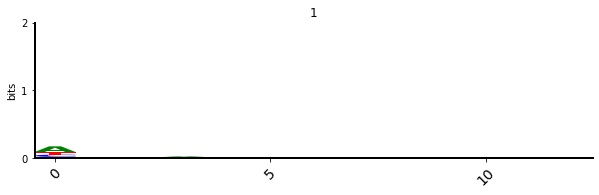

In [45]:
lm_filter_viz(
    sdata_leaf,
    filter_id=1,
    uns_key="pfms"
)

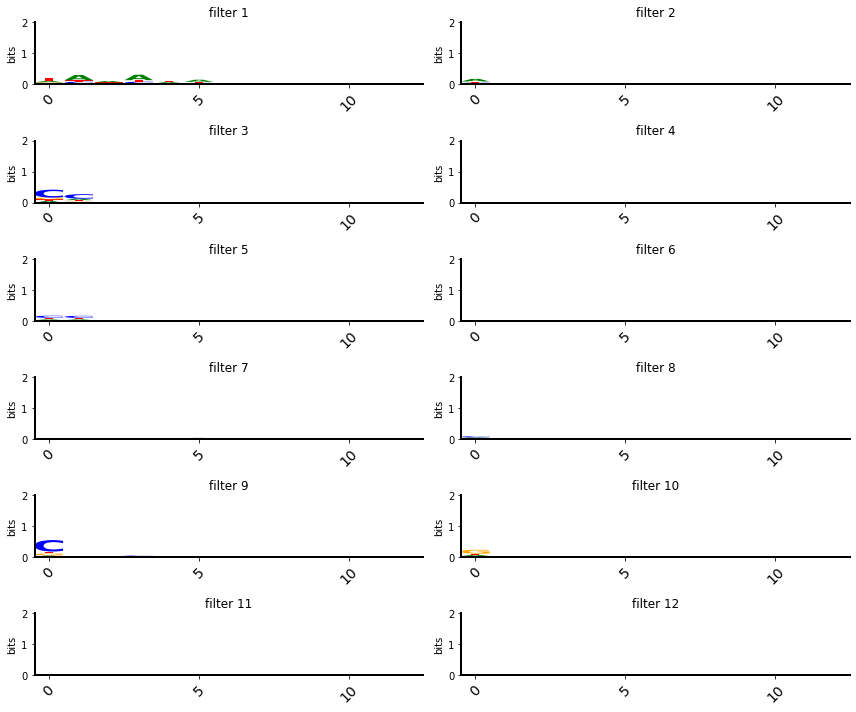

In [49]:
lm_multifilter_viz(
    sdata_leaf,
    filter_ids=list(sdata_leaf.uns["pfms"].keys()),
    num_rows=6,
    num_cols=2,
    titles=[f"filter {i}" for i in range(1, len(sdata_leaf.uns["pfms"])+1)],
)

In [47]:
filter_ids=range(12)

In [150]:
info_mat = logomaker.transform_matrix(pfm, 
                                      from_type='counts', 
                                      to_type='information')

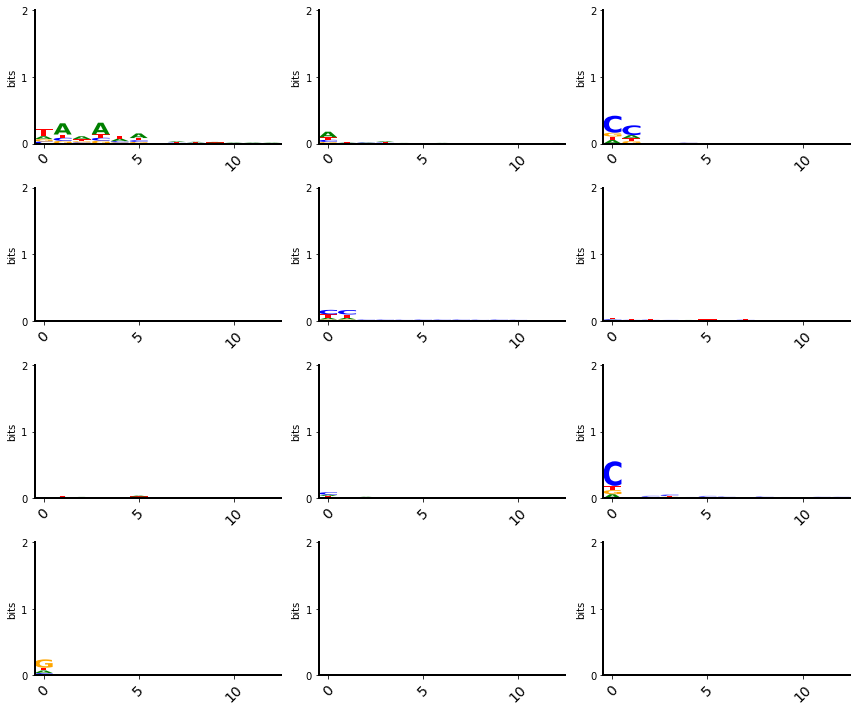

In [191]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,10))
for i in range(num_rows):
    for j in range(num_cols):
        filter_id = filter_ids[i*num_cols+j]
        pfm=sdata_leaf.uns["pfms"][filter_id]
        info_mat = logomaker.transform_matrix(
            pfm, 
            from_type='counts', 
            to_type='information')
        logo = logomaker.Logo(
            info_mat,
            font_name = 'Arial Rounded MT Bold',
            ax=ax[i,j])
        logo.style_xticks(spacing=5, anchor=25, rotation=45, fmt='%d', fontsize=14)
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left','bottom'], visible=True, linewidth=2)

        logo.ax.set_ylim([0, 2])
        logo.ax.set_yticks([0, 1, 2])
        logo.ax.set_yticklabels(['0', '1', '2'])
        logo.ax.set_ylabel('bits')
plt.tight_layout()
plt.savefig('../../_output/jores21/pfms.pdf')


In [51]:
eu.settings.output_dir

PosixPath('/workspaces/EUGENe/tests/_output/jores21')

In [54]:
os.path.join(eu.settings.output_dir, f"leaf_filter_{filter_id}.png")

'/workspaces/EUGENe/tests/_output/jores21/leaf_filter_11.png'

In [92]:
for filter_id in filter_ids:
    pfm=sdata_leaf.uns["pfms"][filter_id]
    cpm = seqlogo.CompletePm(pfm=pfm)
    logo = seqlogo.seqlogo(
        cpm, 
        ic_scale=True, 
        format="png", 
        size="xlarge",
        filename=os.path.join(eu.settings.output_dir, "fig", f"leaf_filter_{filter_id}.png")
    )
    

In [77]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(20,10))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')

In [81]:
num_rows = 4
num_cols = 3

In [85]:
import matplotlib

In [86]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

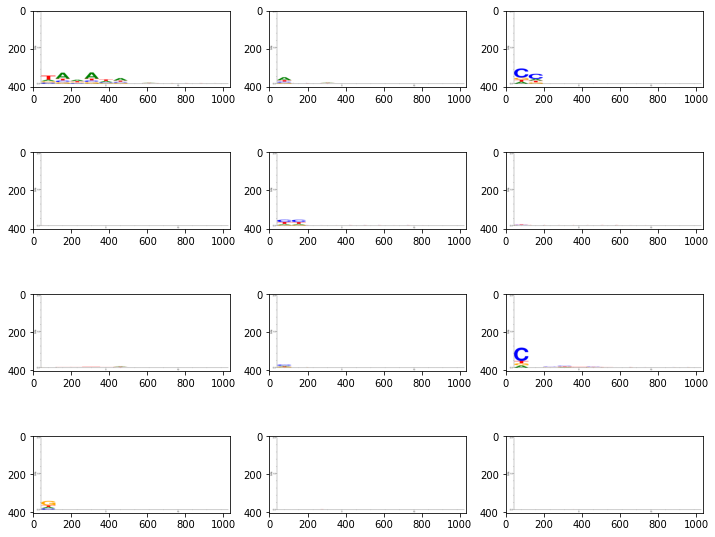

In [95]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,10))
for i in range(num_rows):
    for j in range(num_cols):
        ax[i,j].imshow(imread(os.path.join(eu.settings.output_dir, "fig", f"leaf_filter_{i*num_cols+j}.png")))
        #ax[i,j].axis('off')
#plt.savefig(os.path.join(eu.settings.output_dir, "fig", "leaf_filters.pdf"))

In [96]:
cpm

,A,C,G,T
0,0.270214,0.266562,0.200313,0.262911
1,0.269916,0.231656,0.225367,0.273061
2,0.222694,0.270414,0.243372,0.263521
3,0.265208,0.229456,0.251868,0.253469
4,0.299141,0.237379,0.196563,0.266917
5,0.261480,0.238250,0.240951,0.259319
6,0.232824,0.254635,0.239913,0.272628
7,0.268829,0.244640,0.218802,0.267730
8,0.249724,0.242541,0.236464,0.271271
9,0.252918,0.235686,0.241801,0.269594


findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


Running /home/vscode/.local/lib/python3.7/site-packages/logomaker/examples/demo_fig1b.py:
-------------------------------------------------------------
# do imports
import matplotlib.pyplot as plt
import logomaker as logomaker

# load crp energy matrix
crp_df = -logomaker.get_example_matrix('crp_energy_matrix',
                                        print_description=False)

# create Logo object
crp_logo = logomaker.Logo(crp_df,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold')

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)

# style and show figure
crp_logo.fig.show()
----------

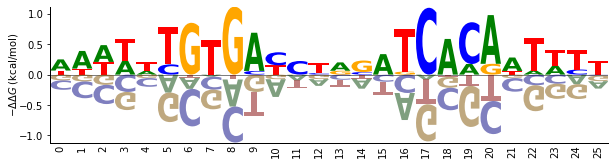

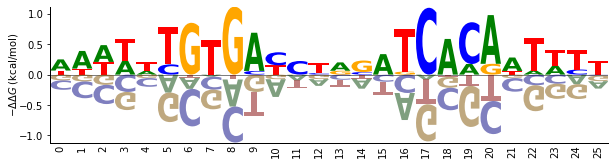

In [145]:
logomaker.demo('fig1b')

In [78]:
import glob

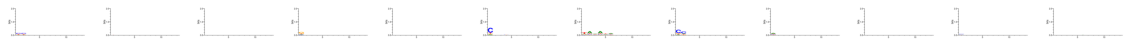

In [79]:
showImagesHorizontally(glob.glob("../../_output/jores21/fig/*filter*.png"))

In [13]:
import seqlogo

In [46]:
type(logo)

IPython.core.display.Image

In [97]:
pfm=sdata_leaf.uns["pfms"][0]
print(pfm)

         A      C      G       T
0    671.0  504.0  571.0  1793.0
1   1963.0  539.0  471.0   566.0
2   1378.0  557.0  562.0  1042.0
3   1979.0  493.0  487.0   580.0
4   1111.0  550.0  526.0  1345.0
5   1619.0  600.0  569.0   741.0
6    933.0  877.0  800.0   902.0
7   1160.0  733.0  674.0   935.0
8   1068.0  730.0  684.0  1001.0
9   1098.0  734.0  701.0   936.0
10  1057.0  748.0  703.0   946.0
11  1063.0  748.0  700.0   923.0
12  1026.0  719.0  721.0   952.0


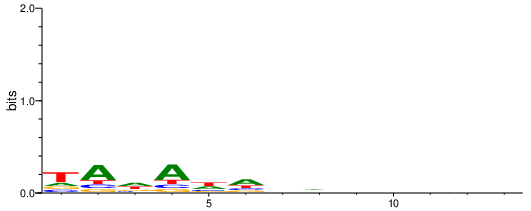

In [105]:
seqlogo.seqlogo(cpm, ic_scale = True, format = 'png', size = 'medium')

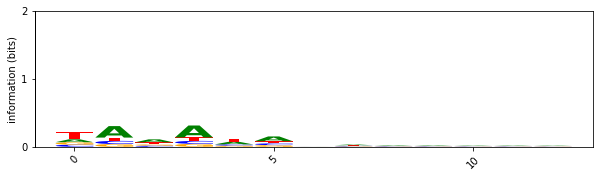

In [147]:
# create Logo object
logo = logomaker.Logo(scaled_cpm, font_name="Arial Rounded MT Bold")

# style using Logo methods
logo.style_spines(spines=['left'], visible=True, bounds=[0, 2])
logo.style_xticks(anchor=0, spacing=5, rotation=45)

# style using Axes methods
logo.ax.set_ylabel('information (bits)')
logo.ax.set_xlim([-1, len(scaled_cpm)])
logo.ax.set_ylim([0, 2])
logo.ax.set_yticks([0, 1, 2])

Text(0, 0.5, 'bits')

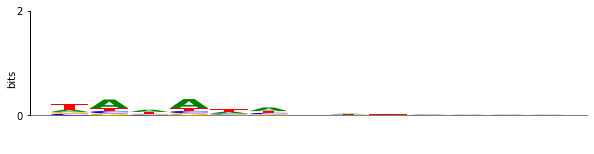

In [133]:
logo = logomaker.Logo(scaled_cpm)

# style using Logo methods
logo.style_spines(visible=False)
logo.style_spines(spines=['left'], visible=True, bounds=[0, 2])

# style using Axes methods
logo.ax.set_xlim([-1, 13])
logo.ax.set_xticks([])
logo.ax.set_ylim([-.6, 2])
logo.ax.set_yticks([0, 2])
logo.ax.set_yticklabels(['0', '2'])
logo.ax.set_ylabel('bits', labelpad=-1)


In [122]:
import logomaker

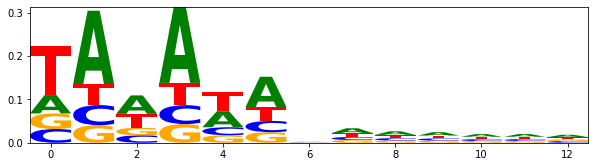

In [123]:
scaled_cpm = cpm.ppm.multiply(cpm.ic, axis=0)

In [116]:
type(cpm.ic)

pandas.core.series.Series

In [99]:
print(cpm.ic)

0     0.223089
1     0.304707
2     0.109353
3     0.313567
4     0.117777
5     0.152365
6     0.002294
7     0.033520
8     0.026423
9     0.024459
10    0.020080
11    0.020188
12    0.018531
dtype: float64


In [98]:
cpm = seqlogo.CompletePm(pfm=sdata_leaf.uns["pfms"][0])
print(cpm)

,A,C,G,T
0,0.189602,0.142413,0.161345,0.506640
1,0.554676,0.152303,0.133088,0.159932
2,0.389376,0.157389,0.158802,0.294433
3,0.559198,0.139305,0.137609,0.163888
4,0.314553,0.155719,0.148924,0.380804
5,0.458770,0.170020,0.161235,0.209974
6,0.265661,0.249715,0.227790,0.256834
7,0.331239,0.209309,0.192461,0.266990
8,0.306632,0.209589,0.196382,0.287396
9,0.316518,0.211588,0.202076,0.269818


In [42]:
logos = [logo]*5

In [44]:
logo[i]

TypeError: 'Image' object is not subscriptable

In [ ]:
ax[0].

TypeError: Image data of dtype object cannot be converted to float

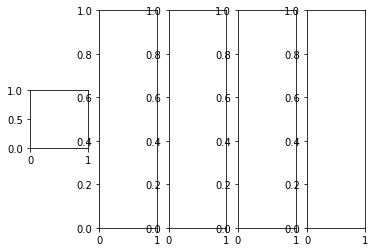

In [45]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,5)
for i in range(2):
    ax[i].imshow(logos[i])
plt.show() # or display.display(plt.gcf()) if you prefer

In [41]:
seqlogo.seqlogo?

Signature:
seqlogo.seqlogo(
    pm,
    ic_scale=True,
    color_scheme=None,
    size='medium',
    format='svg',
    filename=None,
    **kwargs,
)
Docstring:
The plotting method of the `seqlogo` distribution. Depends on using
any of the 3 classes exposed by `seqlogo`:
    * `seqlogo.Ppm`
    * `seqlogo.Pwm`
    * `seqlogo.CompletePm`

Given an `M x N` PM matrix, where `M` is the number of positions and `N`
is the number of letters, calculate and render a WebLogo-like motif plot.

When `ic_scale` is `True`, the height of each column is proportional to 
its information content. The y-axis label and scale will reflect information
content. Otherwise, all columns have the same height and y-axis label will
reflect "bits"

Args:
    pm (`seqlogo.Pm` subclass): a pre-formatted Pm instance
    ic_scale (bool): whether or not to scale the column heights (default: True)
    size (str): small (3.54 in), medium (5 in), large (7.25 in), xlarge (10.25) (default: 'medium')
    format (str): desired

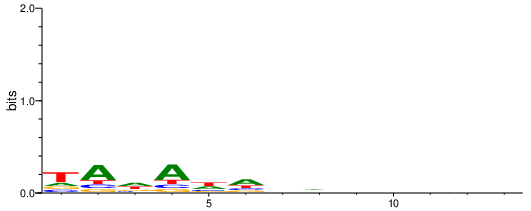

In [38]:
logo = seqlogo.seqlogo(cpm, ic_scale=True, format="png")
display(logo)

In [34]:
type(logo)

IPython.core.display.Image

In [27]:
images = [logo, logo]

In [28]:
import matplotlib.pyplot as plt

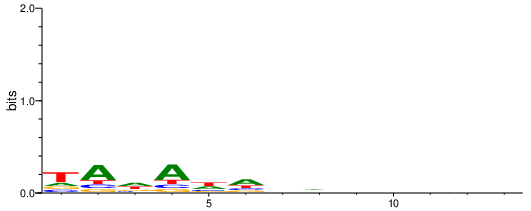

<Figure size 432x288 with 0 Axes>

In [31]:
plt.figure()
display(logo) 

---

# Scratch

In [ ]:
import matplotlib.pyplot as plt
from eugene.plotting._seq import _plot_seq_logo
from tqdm.auto import tqdm
uns_keys = [method + "_imps" for method in ["InputXGradient", "DeepLift", "GradientSHAP", "NaiveISM"]]
ylabels = ["InputXGradient", "DeepLift", "GradientSHAP", "NaiveISM"]
seq_id = sdata.names[:2]
if isinstance(seq_id, str):
    seq_id = [seq_id]
if isinstance(uns_keys, str):
    uns_keys = [uns_keys]
seq_idx = np.where(sdata.seqs_annot.index.isin(seq_id))[0]
seqs = sdata.seqs[seq_idx]
print(seq_id, uns_keys, seq_idx, seqs)
fig_width = len(seq_id) * int(len(seqs[0]) / 20) # make each sequence width proportional to its length and multiply by the number of sequences
fig_height = len(uns_keys)*6
_, ax = plt.subplots(len(uns_keys), len(seq_id), figsize=(fig_width, fig_height))
for i, uns_key in tqdm(enumerate(uns_keys), desc=f"Importance values", position=0):
    for j, seq in tqdm(enumerate(seqs), desc=f"Plotting sequence", position=1):
        imp_scores = sdata.uns[uns_key][seq_idx[j]] if uns_key in sdata.uns.keys() else None
        _plot_seq_logo(
            ax.flatten()[i*len(seq_id)+j],
            seq,
            imp_scores=imp_scores,
            ylab=ylabels[i],
        )
        if i == 0:
            print(j*len(uns_keys))
            ax.flatten()[i*len(seq_id)+j].set_title(seq_id[j], fontsize=18, weight="bold")
plt.tight_layout()